In [1]:
import os
import tweepy as tw
import pandas as pd
import numpy as np

In [2]:
# 请问在这里自行申请：
# https://developer.twitter.com/en/apps
consumer_key= ''
consumer_secret= ''
access_token= ''
access_token_secret= ''

In [3]:
# 实例化一个 OAuthHandler，设置 token，实例化 API
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True, proxy="127.0.0.1:10818")

In [4]:
# 设置关键词和时间，去除 rewteets
search_words = "#coronavirus"
date_since = "2020-01-01"
new_search = search_words + " -filter:retweets"

In [5]:
# 开始爬数据
tweets = tw.Cursor(api.search, 
                   q=new_search,
                   lang="en",
                   since=date_since).items(5000)

In [6]:
# 提取你感兴趣的列
# Tweet objects: https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object
latest_tweets = [[tweet.created_at, tweet.favorite_count, tweet.retweet_count, tweet.lang, tweet.text, 
                  tweet.user.screen_name, tweet.user.location, tweet.coordinates] for tweet in tweets]

In [51]:
tweet_text = pd.DataFrame(latest_tweets)
tweet_text.columns = ['creates_at', 'favorite_count', 'retweet_count', 'lang', 'text',
                     'user_screen_name', 'user_location', 'coordinates']

In [8]:
tweet_text

,creates_at,favorite_count,retweet_count,lang,text,user_screen_name,user_location,coordinates
0,2020-02-22 10:44:11,0,0,en,#coronavirus coronavirus is circulating and sn...,StarIncredible,,None
1,2020-02-22 10:44:07,0,0,en,Akashic Prophesy of the day: #coronavirus is h...,lostinhdr,,None
2,2020-02-22 10:44:04,0,0,en,"You are a man’s ideal, you are a ruthless mach...",Wanda78291,"Сургут, Россия",None
3,2020-02-22 10:43:58,0,0,en,@BNODesk did you finally went to sleep? I miss...,rozczoch,,None
4,2020-02-22 10:43:53,0,0,en,#SouthKorea will close all borders because of ...,psychic_01,,None
5,2020-02-22 10:43:47,0,0,en,@EmmanuelMacron #OMS #Monde #coronavirus every...,f_f_adiuvat,,None
6,2020-02-22 10:43:43,0,0,en,20 Feb 20\n#coronavirus #COVID19\nDaily report...,BioGraphica1,,None
7,2020-02-22 10:43:43,0,0,en,94 days incubation period is the maximum repor...,ryanfiredragon,,None
8,2020-02-22 10:43:36,0,0,en,"China has now reported 75,569 cases of #corona...",EmNtirenganya,Rwanda,None
9,2020-02-22 10:43:29,0,0,en,@JoeSquawk \n#Samsung Electronics the world's ...,ladyandtheT,,None


In [85]:
# 去掉text中的url
def remove_url(txt):
    import re
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

all_tweets = tweet_text[['text']]
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets['text']]

In [10]:
# 统计推文中出现的高频词语
import itertools
import collections
import nltk
from nltk.corpus import stopwords

words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

all_words_nsw = list(itertools.chain(*tweets_nsw))
counts_nsw = collections.Counter(all_words_nsw)

[nltk_data] Downloading package stopwords to /Users/Cyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
common_words = pd.DataFrame(counts_nsw.most_common(20))
common_words.columns = ['words', 'times']
common_words = common_words.sort_values(by = ['times'])

In [26]:
import plotly.express as px

fig = px.bar(
    common_words, 
    x='times',
    y='words',
    orientation='h'
)
fig.show()

In [86]:
all_tweets

,text
0,#coronavirus coronavirus is circulating and sn...
1,Akashic Prophesy of the day: #coronavirus is h...
2,"You are a man’s ideal, you are a ruthless mach..."
3,@BNODesk did you finally went to sleep? I miss...
4,#SouthKorea will close all borders because of ...
5,@EmmanuelMacron #OMS #Monde #coronavirus every...
6,20 Feb 20\n#coronavirus #COVID19\nDaily report...
7,94 days incubation period is the maximum repor...
8,"China has now reported 75,569 cases of #corona..."
9,@JoeSquawk \n#Samsung Electronics the world's ...


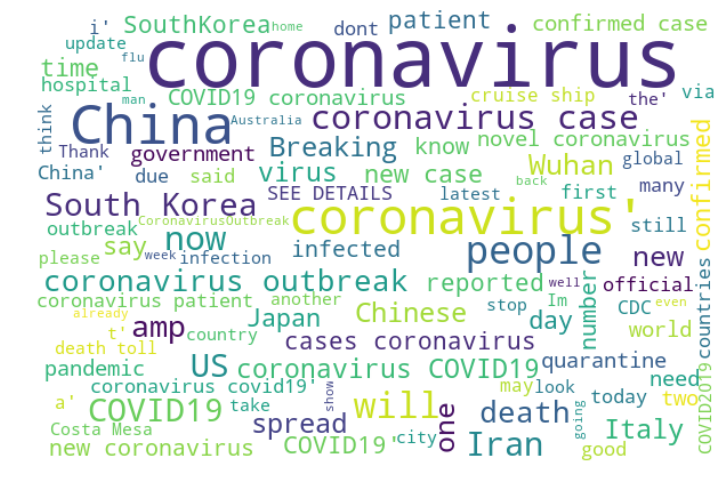

In [95]:
# 绘制图云
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

text = all_tweets_no_urls
#mask = np.array(Image.open('virus.png'))

wordcloud = WordCloud(
    width = 600,
    height = 400,
    max_words=100,
    #mask = mask,
    background_color = 'rgba(255, 255, 255, 0)',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (10, 10))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [83]:
# 统计参与话题讨论的人都来自哪些国家
tweet_text['user_location'] = tweet_text['user_location'].apply(lambda x: x.split(','))
tweet_text['user_location'] = tweet_text['user_location'].apply(lambda x: x[-1] if len(x)>1 else x[0])
tweet_text['user_location'] = tweet_text['user_location'].apply(lambda x: x.replace(' ', ''))

In [55]:
user_loc = pd.DataFrame(tweet_text['user_location'].value_counts()).reset_index()
user_loc.columns = ['area', 'count']

In [57]:
user_loc = user_loc.iloc[1:21, :]
user_loc = user_loc.sort_values(by = ['count'])

In [58]:
fig = px.bar(
    user_loc, 
    x='count',
    y='area',
    orientation='h'
)
fig.update_traces(marker_color='rgb(222,184,135)')
fig.show()

In [96]:
tweet_text.head()

,creates_at,favorite_count,retweet_count,lang,text,user_screen_name,user_location,coordinates
0,2020-02-22 10:44:11,0,0,en,#coronavirus coronavirus is circulating and sn...,StarIncredible,,None
1,2020-02-22 10:44:07,0,0,en,Akashic Prophesy of the day: #coronavirus is h...,lostinhdr,,None
2,2020-02-22 10:44:04,0,0,en,"You are a man’s ideal, you are a ruthless mach...",Wanda78291,Россия,None
3,2020-02-22 10:43:58,0,0,en,@BNODesk did you finally went to sleep? I miss...,rozczoch,,None
4,2020-02-22 10:43:53,0,0,en,#SouthKorea will close all borders because of ...,psychic_01,,None


In [99]:
from textblob import TextBlob

sentiment_objects = [TextBlob(tweet) for tweet in all_tweets_no_urls]
sentiment_objects[0].polarity, sentiment_objects[0]

(-0.35,
 TextBlob("coronavirus coronavirus is circulating and sneezing closely us It is linked to travel in an closed cold market R"))

In [111]:
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

In [124]:
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
sentiment_df.head()

,polarity,tweet
0,-0.350,coronavirus coronavirus is circulating and sne...
1,-0.125,Akashic Prophesy of the day coronavirus is hoa...
2,-0.050,You are a mans ideal you are a ruthless macho ...
3,0.500,BNODesk did you finally went to sleep I miss m...
4,0.000,SouthKorea will close all borders because of c...


In [125]:
sentiment_df['polarity'] = sentiment_df['polarity'].apply(lambda x: '积极' if x>0
                                                     else '消极' if x<0
                                                     else '中立')

In [126]:
tweets_polarity = pd.DataFrame(sentiment_df['polarity'].value_counts()).reset_index()
tweets_polarity.columns = ['polarity', 'count']

In [127]:
import plotly.express as px

df = px.data.tips()
fig = px.pie(tweets_polarity, 
             values='count', 
             names='polarity')
fig.show()